In [1]:
import torch
from torchvision.models.detection import keypointrcnn_resnet50_fpn

# Загружаем предобученную модель
model = keypointrcnn_resnet50_fpn(pretrained=True)

# Переводим модель в режим инференса
model.eval()

# Если доступен GPU, переносим модель на него
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


d:\SF-Projects\ComputerVision\Diplom\pose_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SF-Projects\ComputerVision\Diplom\pose_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [2]:
print(torch.cuda.get_device_name(0))  # Название видеокарты, если она есть


NVIDIA GeForce GTX 1660 SUPER


In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)           
print(torch.cuda.is_available())   


2.1.0+cu118
11.8
True


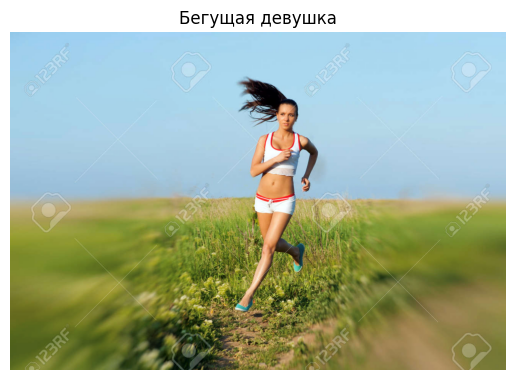

In [ ]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Список ключевых точек COCO
keypoints_names = [
    'nose', 'left_eye', 'right_eye',
    'left_ear', 'right_ear', 'left_shoulder',
    'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip',
    'right_hip', 'left_knee', 'right_knee',
    'left_ankle', 'right_ankle'
]

# Загрузка изображения
img_path = 'data/dspr_cv_u1_diploma_spr1_3_1.png'
image = Image.open(img_path).convert("RGB")
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).to(device)  # переместить тензор на GPU

# Визуализация (по желанию)
plt.imshow(image)
plt.axis("off")
plt.title("Бегущая девушка")
plt.show()


In [ ]:
# Инференс
with torch.no_grad():
    output = model([image_tensor])[0]  # batch из 1 изображения

# Получение ключевых точек
# (ключевые точки каждого объекта — список из (x, y, score), shape: [N, 17, 3])
keypoints = output['keypoints']
scores = output['scores']

# Фильтрация: оставим только предсказания с уверенность > 0.9
threshold = 0.9
if scores[0] > threshold:
    print("Ключевые точки первого человека:")
    print(keypoints[0])  # тензор размера [17, 3]
else:
    print("Человек не распознан или уверенность < 0.9")

Ключевые точки первого человека:
tensor([[724.5498, 228.4089,   1.0000],
        [736.7170, 218.4422,   1.0000],
        [715.7010, 217.3347,   1.0000],
        [751.0963, 226.1940,   1.0000],
        [700.2155, 218.4422,   1.0000],
        [762.1574, 287.1017,   1.0000],
        [665.9263, 285.9943,   1.0000],
        [795.3405, 319.2167,   1.0000],
        [639.3798, 363.5132,   1.0000],
        [778.7490, 381.2318,   1.0000],
        [700.2155, 334.7205,   1.0000],
        [720.1254, 447.6765,   1.0000],
        [661.5018, 445.4617,   1.0000],
        [676.9873, 567.2771,   1.0000],
        [685.8362, 567.2771,   1.0000],
        [631.6370, 682.4480,   1.0000],
        [748.8842, 578.3511,   1.0000]], device='cuda:0')


In [6]:
import numpy as np
import cv2

def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):
    cmap = plt.get_cmap("rainbow")
    img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]

    for person_id in range(len(all_keypoints)):
        if confs[person_id] > conf_threshold:
            keypoints = all_keypoints[person_id, ...]
            scores = all_scores[person_id, ...]
            for kp in range(len(scores)):
                if scores[kp] > keypoint_threshold:
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().cpu().numpy().tolist())
                    )
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy


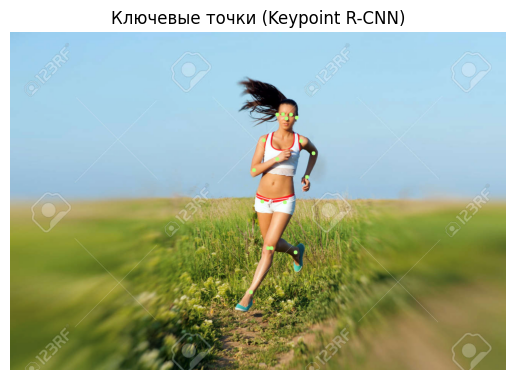

In [8]:
import numpy as np
import cv2

# Получаем необходимые данные из инференса
all_keypoints = output["keypoints"]                # [N, 17, 3]
all_scores = output["keypoints"][..., 2]           # [N, 17] — confidence каждой точки
confs = output["scores"]                           # [N] — уверенность для каждого человека

# Переводим изображение в формат BGR для OpenCV
img_cv = np.array(image)[:, :, ::-1].copy()        # RGB -> BGR

# Отрисовываем ключевые точки
result_img = draw_keypoints_per_person(
    img_cv, all_keypoints, all_scores, confs,
    keypoint_threshold=0.5,
    conf_threshold=0.5
)


# Отображаем результат
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Ключевые точки (Keypoint R-CNN)")
plt.show()


In [9]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs


limbs = get_limbs_from_keypoints(keypoints_names)

In [10]:
def draw_skeleton_per_person(
    img, all_keypoints, all_scores, confs, limbs,
    keypoint_threshold=2, conf_threshold=0.9
):
    cmap = plt.get_cmap("rainbow")
    img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]

    for person_id in range(len(all_keypoints)):
        if confs[person_id] > conf_threshold:
            keypoints = all_keypoints[person_id, ...]
            scores = all_scores[person_id, ...]
            for limb in limbs:
                p1, p2 = limb
                if scores[p1] > keypoint_threshold and scores[p2] > keypoint_threshold:
                    pt1 = tuple(map(int, keypoints[p1, :2].detach().cpu().numpy().tolist()))
                    pt2 = tuple(map(int, keypoints[p2, :2].detach().cpu().numpy().tolist()))
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    cv2.line(img_copy, pt1, pt2, color, thickness=2)

    return img_copy


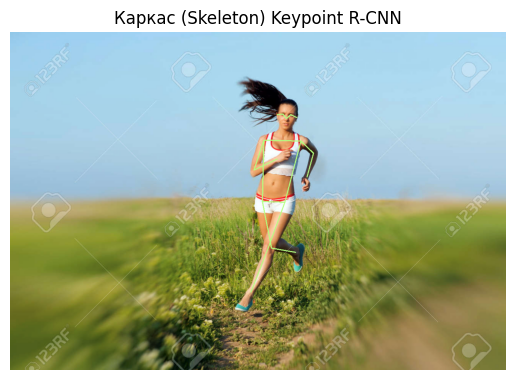

In [11]:
# Используем те же данные из инференса
all_keypoints = output["keypoints"]
all_scores = output["keypoints"][..., 2]
confs = output["scores"]

# Преобразуем изображение
img_cv = np.array(image)[:, :, ::-1].copy()

# Рисуем каркас
skeleton_img = draw_skeleton_per_person(
    img_cv, all_keypoints, all_scores, confs, limbs,
    keypoint_threshold=0.5, conf_threshold=0.5
)

# Отображаем результат
plt.imshow(cv2.cvtColor(skeleton_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Каркас (Skeleton) Keypoint R-CNN")
plt.show()


In [12]:
# Загрузка второго изображения 
img_path2 = 'data/test.jpg'
image2 = Image.open(img_path2).convert("RGB")
image_tensor2 = transform(image2).to(device)

# Инференс
with torch.no_grad():
    output2 = model([image_tensor2])[0]

# Извлекаем ключевые точки
keypoints2 = output2['keypoints']
scores2 = output2['scores']


In [13]:
threshold = 0.9
if scores2[0] > threshold:
    user_keypoints = keypoints2[0][:, :2].cpu().numpy()  # [17, 2]
else:
    print("Человек не распознан или уверенность < 0.9")


In [14]:
model_keypoints = keypoints[0][:, :2].cpu().numpy()  # из первого изображения


In [15]:
def pad(x): return np.hstack([x, np.ones((x.shape[0], 1))])
def unpad(x): return x[:, :-1]

X = pad(user_keypoints)
Y = pad(model_keypoints)

A, _, _, _ = np.linalg.lstsq(X, Y, rcond=None)
user_aligned = unpad(np.dot(X, A))


In [16]:
def draw_limbs_from_indices(keypoints_xy, limbs_indices, color='r', label=''):
    for i, j in limbs_indices:
        if i < len(keypoints_xy) and j < len(keypoints_xy):
            x1, y1 = keypoints_xy[i]
            x2, y2 = keypoints_xy[j]
            plt.plot([x1, x2], [y1, y2], color=color)
    plt.scatter(keypoints_xy[:, 0], keypoints_xy[:, 1], c=color, label=label)


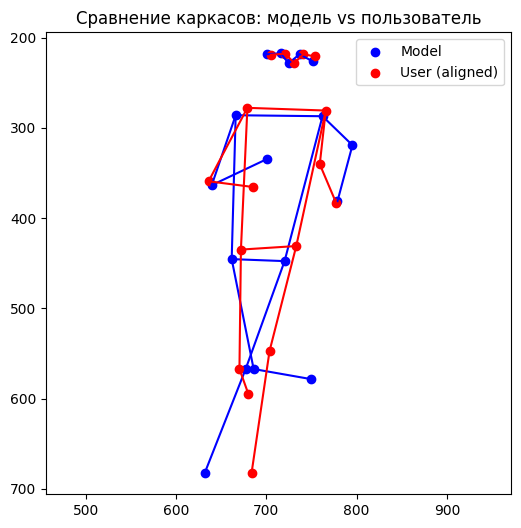

In [17]:
def draw_limbs(keypoints, color='r', label=''):
    limbs = get_limbs_from_keypoints(keypoints)
    for x1, y1, x2, y2 in limbs:
        plt.plot([x1, x2], [y1, y2], color=color)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c=color, label=label)

limbs_indices = get_limbs_from_keypoints(keypoints_names)

plt.figure(figsize=(6, 6))
draw_limbs_from_indices(model_keypoints, limbs_indices, color='blue', label='Model')
draw_limbs_from_indices(user_aligned, limbs_indices, color='red', label='User (aligned)')
plt.legend()
plt.title("Сравнение каркасов: модель vs пользователь")
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()


In [18]:
def procrustes_distance(X, Y):
    Xc = X - X.mean(0)
    Yc = Y - Y.mean(0)
    Xn = Xc / np.linalg.norm(Xc)
    Yn = Yc / np.linalg.norm(Yc)
    return np.linalg.norm(Xn - Yn)

distance = procrustes_distance(user_aligned, model_keypoints)
print(f"Прокрустово расстояние: {distance:.4f}")


Прокрустово расстояние: 0.1831


In [ ]:
if distance < 0.1:
    print("Позы совпадают хорошо ✅")
elif distance < 0.25:
    print("Позы похожи, но есть отклонения ⚠️")
else:
    print("Позы сильно отличаются ❌")


Позы похожи, но есть отклонения ⚠️


In [20]:
def cosine_distance(pose1, pose2):
    # flatten -> превращаем 17x2 в вектор длины 34
    pose1 = pose1.flatten()
    pose2 = pose2.flatten()
    
    dot = np.dot(pose1, pose2)
    norm1 = np.linalg.norm(pose1)
    norm2 = np.linalg.norm(pose2)

    if norm1 == 0 or norm2 == 0:
        return 0.0  # если поза пустая
    cossim = dot / (norm1 * norm2)
    return cossim


In [21]:
import math

def weight_distance(pose1, pose2, conf1):
    # Преобразуем в векторы: [x0, y0, x1, y1, ..., x16, y16]
    p1 = pose1.flatten()
    p2 = pose2.flatten()

    # Создаем список весов: [c0, c0, c1, c1, ..., c16, c16]
    weights = np.repeat(conf1, 2)

    diff = np.abs(p1 - p2)
    weighted = weights * diff
    return np.sum(weighted) / np.sum(conf1)


In [22]:
# model_keypoints и user_aligned: shape [17, 2]
# conf1 — доверие к каждой точке (из output['keypoints'][..., 2])
conf1 = output['keypoints'][0, :, 2].cpu().numpy()

cos_dist = cosine_distance(model_keypoints, user_aligned)
w_dist = weight_distance(model_keypoints, user_aligned, conf1)

print(f"Косинусное сходство: {cos_dist:.4f}")
print(f"Взвешенное расстояние: {w_dist:.4f}")


Косинусное сходство: 0.9994
Взвешенное расстояние: 25.0362


### 📊 **Результаты сравнения поз**

| Метрика                   | Значение   | Интерпретация                                      |
|---------------------------|------------|----------------------------------------------------|
| **Косинусное сходство**   | `0.9994`   | 🔵 Позы имеют почти идентичную форму и ориентацию  |
| **Взвешенное расстояние** | `25.04`    | 🟡 Умеренное расхождение по точкам (в пикселях)     |

---

### 🧠 **Вывод:**
Пользователь **хорошо повторил позу**:
- Форма и направления суставов совпадают почти идеально.
- Есть незначительные отклонения в позиционировании тела.
